In [39]:
import time
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import requests
import matplotlib.pyplot as plt
import seaborn as sns

---

## В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

In [40]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4


### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

---

In [87]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2705.000000,2705.000000,2705.000000
mean,6863.716821,6867.454159,233.496386
std,1485.841307,1479.610955,127.420245
min,0.000000,0.000000,0.000000
25%,5811.000000,5829.000000,143.650000
50%,6697.000000,6689.000000,217.475000
75%,7774.000000,7775.500000,299.425000
max,10730.000000,10720.000000,678.225000


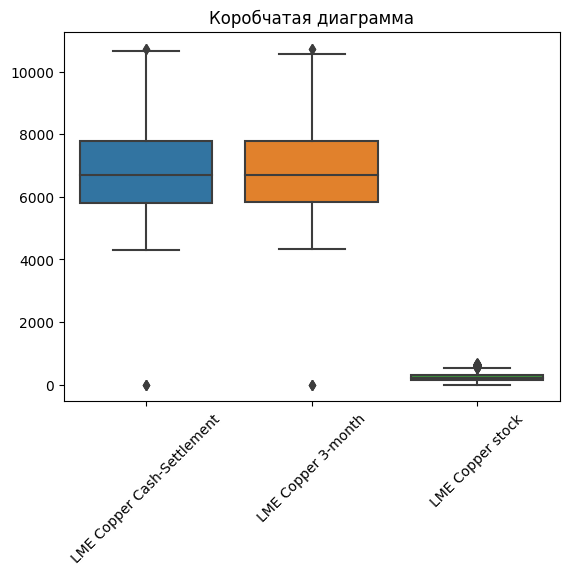

In [88]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2701.000000,2701.000000,2701.000000
mean,6871.784154,6875.518697,233.584163
std,1469.031202,1462.706069,127.412493
min,4310.500000,4320.500000,51.175000
25%,5813.000000,5830.500000,143.650000
50%,6699.500000,6689.000000,217.550000
75%,7777.000000,7777.000000,299.425000
max,10730.000000,10720.000000,678.225000


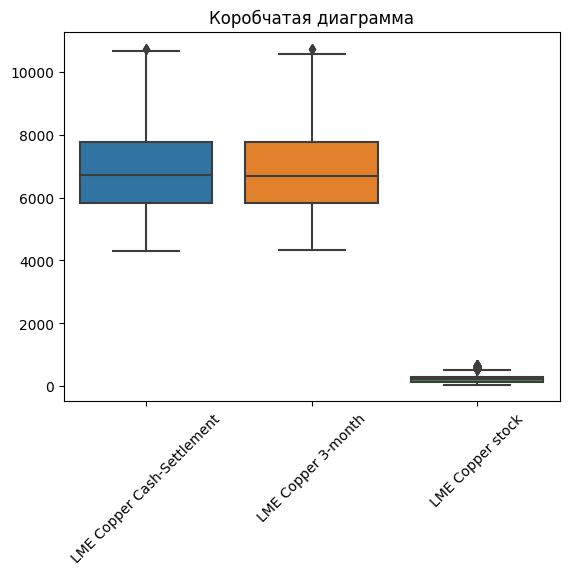

In [89]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

In [90]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [91]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Copper 3-month'] = data['LME Copper 3-month'].shift(90)

# Обрежем 13 год, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2013]

display(data.head(), data.tail())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
364,2014-01-01,7417.000000,7245.5,365.700000
365,2014-01-02,7439.500000,7182.0,365.700000
366,2014-01-03,7335.500000,7189.5,359.075000
367,2014-01-04,7328.166667,7197.0,358.091667
368,2014-01-05,7320.833333,7204.5,357.108333


,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
85,2023-12-06,NaN,8242.000000,NaN
86,2023-12-07,NaN,8281.333333,NaN
87,2023-12-08,NaN,8320.666667,NaN
88,2023-12-09,NaN,8360.000000,NaN
89,2023-12-10,NaN,8365.000000,NaN


In [45]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data['LME Copper stock'].isna()]

# А так же ту часть, которую будем использовать для работы
working_data = data[~data['LME Copper stock'].isna()]

In [46]:
# Будем прогнозировать временной ряд LME Copper stock, т.к. данная переменная имеет непосредственную связь с фактором времени
# baseline-ом выделить timeseries prog для спота

In [52]:
# Функция для проверки ряда на стационарность
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
